<a href="https://colab.research.google.com/github/Sokolov-AA/ML_Study/blob/main/platesv2/PlatesKaggle_v4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install kaggle

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c platesv2
# !unzip platesv2.zip
# !unzip plates.zip

# !mv /content/plates/test /content/plates/unknown
# !mkdir /content/plates/test
# !mv /content/plates/unknown /content/plates/test/unknown

# import os
# import shutil
# import cv2
# import numpy as np



# def split_sample(src_folder, dst_folder_train, dst_folder_validation, validation_count, file_type='.jpg'):
#   os.makedirs(dst_folder_train)
#   os.makedirs(dst_folder_validation)

#   for dirs, folder, files in os.walk(src_folder):
#     images = list(filter(lambda file: file.endswith(file_type), files))
#     for i in range(len(images)):
#       if i < validation_count:
#         shutil.copyfile(src_folder + images[i], dst_folder_validation + images[i])
#       else:
#         shutil.copyfile(src_folder + images[i], dst_folder_train + images[i])



# def remove_background_from_image(image_filename_in, image_filename_out, mainRectSize = .08, fgSize = .01):
#   image = cv2.imread(image_filename_in)
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#   new_h, new_w = image.shape[:2]

#   bg_w = round(new_w * mainRectSize)
#   bg_h = round(new_h * mainRectSize)
#   bg_rect = (bg_w, bg_h, new_w - bg_w, new_h - bg_h)

#   fg_w = round(new_w * (1 - fgSize) / 2)
#   fg_h = round(new_h * (1 - fgSize) / 2)
#   fg_rect = (fg_w, fg_h, new_w - fg_w, new_h - fg_h)

#   mask = np.zeros(image.shape[:2],np.uint8)
#   bgdModel = np.zeros((1,65),np.float64)
#   fgdModel = np.zeros((1,65),np.float64)
  
#   cv2.rectangle(mask, fg_rect[:2], fg_rect[2:4], color=cv2.GC_FGD, thickness=-1)
#   cv2.grabCut(image, mask, bg_rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

#   cv2.rectangle(mask, bg_rect[:2], bg_rect[2:4], color=cv2.GC_PR_BGD, thickness=bg_w * 3)
#   cv2.grabCut(image, mask, bg_rect, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_MASK)

#   mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
#   image = image*mask2[:,:,np.newaxis]

#   cv2.imwrite(image_filename_out, image)


# def remove_background_for_filetype(src_folder, file_type='.jpg'):
#   (_, _, filenames) = next(os.walk(src_folder))
#   filenames = list(filter(lambda file: file.endswith(file_type), filenames))
#   for filename in filenames:
#     file_path = src_folder + filename
#     remove_background_from_image(file_path, file_path)


# train_sample_path = '/content/plates/modified/train/'
# validation_sample_path = '/content/plates/modified/validation/'
# test_sample_path = '/content/plates/test/'

# split_sample('/content/plates/train/cleaned/', 
#              train_sample_path + 'cleaned/', 
#              validation_sample_path + 'cleaned/',
#              validation_count=4,
#              file_type='.jpg'
#              )

# split_sample('/content/plates/train/dirty/', 
#              train_sample_path + 'dirty/', 
#              validation_sample_path + 'dirty/',
#              validation_count=4,
#              file_type='.jpg'
#              )


# remove_background_for_filetype(train_sample_path + "cleaned/")
# remove_background_for_filetype(train_sample_path + "dirty/")
# remove_background_for_filetype(validation_sample_path + "cleaned/")
# remove_background_for_filetype(validation_sample_path + "dirty/")
# remove_background_for_filetype(test_sample_path + "unknown/")

In [2]:
train_sample_path = '/content/plates/modified/train/'
validation_sample_path = '/content/plates/modified/validation/'
test_sample_path = '/content/plates/test/'

In [3]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


print("TensorFlow verison:", tf.__version__)

TensorFlow verison: 2.8.2


In [4]:
seed = 42
batch_size=8

# Data Pipeline
def resize_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image, label

datagen_train = ImageDataGenerator(
        rotation_range=359,
        shear_range=0.2,
        zoom_range=0.4,
        width_shift_range=0.4,
        height_shift_range=0.4,
        channel_shift_range=20,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

datagen_validation = ImageDataGenerator()

ds_train_flow = datagen_train.flow_from_directory(
    directory=train_sample_path,
    shuffle=True,
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    target_size=(224, 224))

ds_validation_flow = datagen_validation.flow_from_directory(
    directory=validation_sample_path,
    shuffle=True,
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    target_size=(224, 224))

Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [5]:
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False
#base_model.summary()

In [6]:
model = keras.Sequential([
    keras.layers.Input(shape=(224,224,3), batch_size=batch_size),
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu', kernel_regularizer='l2'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu', kernel_regularizer='l1'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid', kernel_regularizer='l2')
])

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=4,
    decay_rate=0.96,
    staircase=True)

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
  loss="binary_crossentropy",
  metrics=['accuracy'])

In [13]:
model.fit(
    ds_train_flow,
    validation_data=ds_validation_flow,
    epochs=50
  )

history = model.history

Epoch 1/50
4/4 [==============================] - 1s 166ms/step - loss: 2.6510 - accuracy: 0.9375 - val_loss: 2.6287 - val_accuracy: 0.8750
Epoch 2/50
4/4 [==============================] - 1s 160ms/step - loss: 2.6264 - accuracy: 0.9375 - val_loss: 2.6269 - val_accuracy: 0.8750
Epoch 3/50
4/4 [==============================] - 1s 152ms/step - loss: 2.5944 - accuracy: 0.9688 - val_loss: 2.6262 - val_accuracy: 0.8750
Epoch 4/50
4/4 [==============================] - 1s 152ms/step - loss: 2.7176 - accuracy: 0.8438 - val_loss: 2.6268 - val_accuracy: 0.8750
Epoch 5/50
4/4 [==============================] - 1s 158ms/step - loss: 2.5966 - accuracy: 0.9688 - val_loss: 2.6279 - val_accuracy: 0.8750
Epoch 6/50
4/4 [==============================] - 1s 154ms/step - loss: 2.6144 - accuracy: 0.9375 - val_loss: 2.6300 - val_accuracy: 0.8750
Epoch 7/50
4/4 [==============================] - 1s 156ms/step - loss: 2.6293 - accuracy: 0.9688 - val_loss: 2.6288 - val_accuracy: 0.8750
Epoch 8/50
4/4 [====

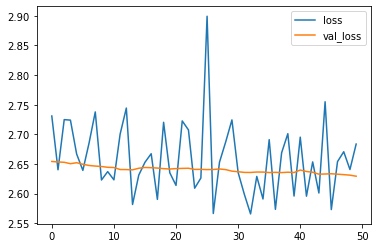

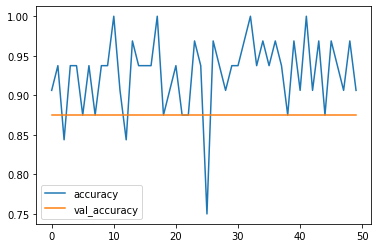

In [12]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [14]:
ds_test_ = keras.preprocessing.image_dataset_from_directory(
    test_sample_path, 
    image_size=[256, 341],
    shuffle=False
)

ds_test = (
    ds_test_
    .map(resize_image)
    .cache()
)

prediction = model.predict(ds_test)

test_prediction = [prediction[i][0] for i in range(len(prediction))]
submission_df = pd.DataFrame.from_dict({'id': ds_test_.file_paths, 'label': test_prediction})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/plates/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)

submission_df.head(n=10)

submission_df.to_csv('submission.csv')

Found 744 files belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.


In [10]:
ds_train_all_ = keras.preprocessing.image_dataset_from_directory(
    train_sample_path, 
    image_size=[256, 341],
    shuffle=False
)

ds_train_all = (
    ds_train_all_
    .map(resize_image)
    .cache()
)

prediction_train_all = model.predict(ds_train_all)

train_prediction = [prediction_train_all[i][0] for i in range(len(prediction_train_all))]
submission_df = pd.DataFrame.from_dict({'id': ds_train_all_.file_paths, 'label': train_prediction})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/plates/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)

submission_df.head(n=40)

Found 32 files belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.


,label
id,
/content/plates/modified/train/cleaned/0000,cleaned
/content/plates/modified/train/cleaned/0003,cleaned
/content/plates/modified/train/cleaned/0004,cleaned
/content/plates/modified/train/cleaned/0005,cleaned
/content/plates/modified/train/cleaned/0006,cleaned
/content/plates/modified/train/cleaned/0007,cleaned
/content/plates/modified/train/cleaned/0008,cleaned
/content/plates/modified/train/cleaned/0009,cleaned
/content/plates/modified/train/cleaned/0011,cleaned
